# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

plt.style.use("seaborn-v0_8-paper")
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn import datasets, decomposition

In [3]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    MinMaxScalerTorch,
    StandardScalerTorch,
    autoencoder_factory,
)

In [37]:
import polcanet.polcanet_reports as report

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load dataset

In [7]:
import torchvision.datasets as datasets

datasets.MNIST
mnist_trainset = datasets.MNIST(root="../../data", train=True, download=True, transform=None)

In [8]:
train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.0
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.0
y_train = mnist_trainset.targets[:-10000].numpy()
y_test = mnist_trainset.targets[-10000:].numpy()
X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
train_dataset.shape, eval_dataset.shape, X.shape, y_train.shape, y_test.shape

(torch.Size([50000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 (50000, 28, 28),
 (50000,),
 (10000,))

### Fit standard sklearn PCA

In [9]:
pca = decomposition.PCA(n_components=28)
pca.fit(np.squeeze(X.reshape(X.shape[0], -1)))
Xpca = pca.transform(X.reshape(X.shape[0], -1))
pca.explained_variance_ratio_

array([0.09744108, 0.07060017, 0.06216173, 0.05379298, 0.04857272,
       0.04319709, 0.03277376, 0.0288645 , 0.02768748, 0.02365975,
       0.02099563, 0.02020426, 0.01715833, 0.01681817, 0.01579296,
       0.0149279 , 0.01318197, 0.01276548, 0.01186538, 0.01151048,
       0.01069133, 0.01007524, 0.00953653, 0.0090788 , 0.00882809,
       0.00836969, 0.00817559, 0.00784815], dtype=float32)

### Fit POLCANet

In [10]:
N = X[0].shape[0]
M = X[0].shape[1]

ae_input = X
act_fn = torch.nn.SiLU
input_dim = ae_input[0].shape
latent_dim = 28
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_conv = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=latent_dim,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    act_fn=act_fn,
)

decoder_conv = LinearDecoder(latent_dim=latent_dim * 4, input_dim=input_dim, hidden_dim=1024, num_layers=2)

model = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim=latent_dim * 4,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda:3",
    # scaler = StandardScalerTorch(),
)
model

PolcaNet(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): SiLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): Conv2d(64, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=112, out_features=1024, bias=True)
      (1): NoActivation()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): NoActivation()
      (4): Linear(in_features=1024, out_features=784, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [11]:
model.to("cuda:1")
model.train_model(data=X, batch_size=512, num_epochs=10000, report_freq=100, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

/data/conda/envs/python312/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716578970623/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Final metrics at epoch: 9999
Total Loss: 0.006067
Reconstruction Loss: 0.005349
Orthogonality Loss: 0.003083
Center of Mass Loss: 0.0003285
Variance Distribution Loss: 8.154e-05


In [12]:
model.train_model(data=X, batch_size=512, num_epochs=1000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.005795
Reconstruction Loss: 0.005231
Orthogonality Loss: 0.002931
Center of Mass Loss: 0.0001847
Variance Distribution Loss: 8.562e-05


In [13]:
model.train_model(data=X, batch_size=512, num_epochs=1000, report_freq=100, lr=1e-5)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.005755
Reconstruction Loss: 0.005202
Orthogonality Loss: 0.002878
Center of Mass Loss: 0.0001842
Variance Distribution Loss: 8.07e-05


## Evaluate results

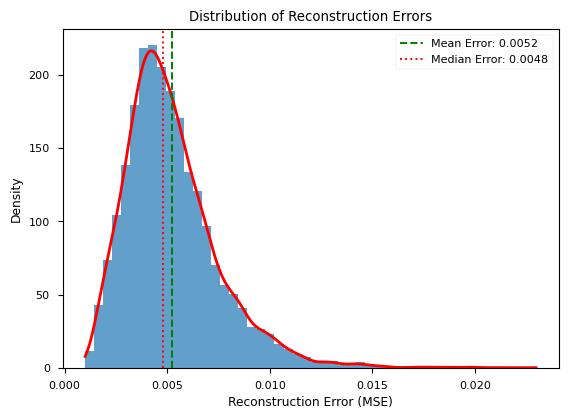

Mean Reconstruction Error: 0.0052
Median Reconstruction Error: 0.0048
Min Reconstruction Error: 0.0010
Max Reconstruction Error: 0.0230


In [14]:
report.analyze_reconstruction_error(model, X)

In [15]:
latents, reconstructed = model.predict(X)

In [16]:
report.analyze_latent_space(model, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 112
Total variance in latent space: 0.0257

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4405
First 5 components              0.9992
Components for 95% variance     4
Variance Concentration Metric   0.9915

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.014
Median absolute off-diagonal          0.0079
Max absolute off-diagonal             0.5106
Proportion of |Orthogonality| > 0.1   0.0092
Orthogonality Success Metric          0.986

Orthogonality Interpretation:
Excellent orthogonality of features.




    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0011
    - Max cosine similarity: 0.7782
    - Min cosine similarity: -0.2005
    


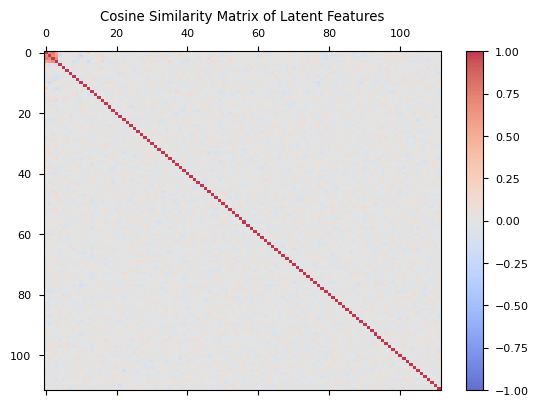

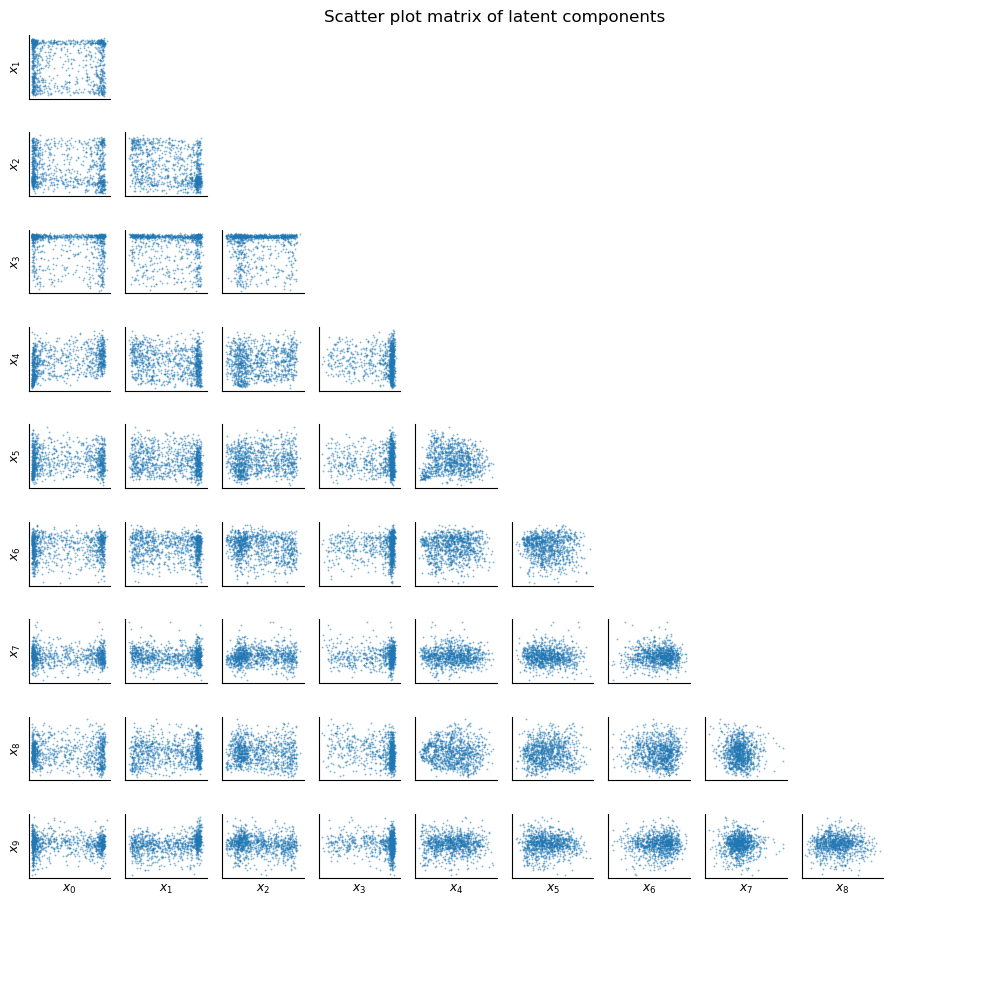

In [17]:
report.orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.9474
    - Variance fit to exponential distribution (sum of squared differences):
     0.0470
    


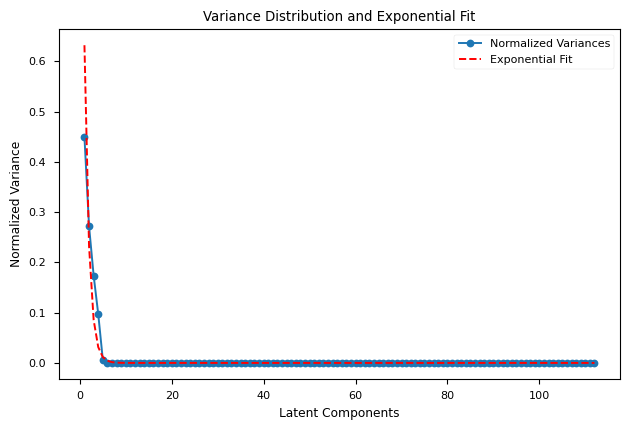

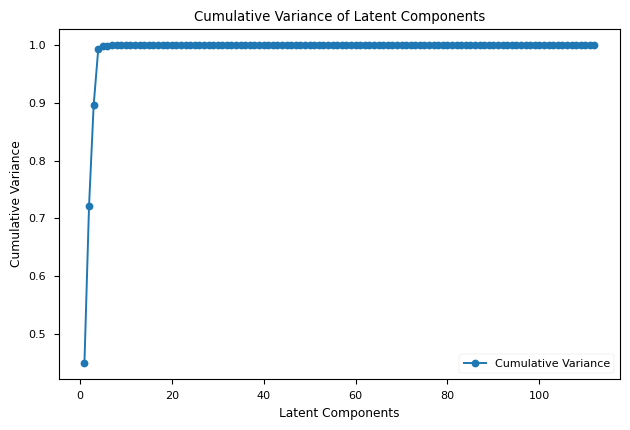

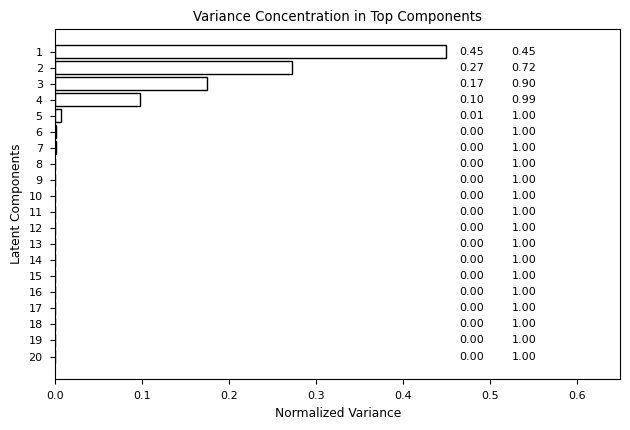

In [18]:
report.variance_test_analysis(model, X)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of
    1000 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z_x + z_y) = f(z_x) + f(z_y)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.1338
    - Max difference: 0.9863
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z_x) = a.f(z_x_)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.1186
  

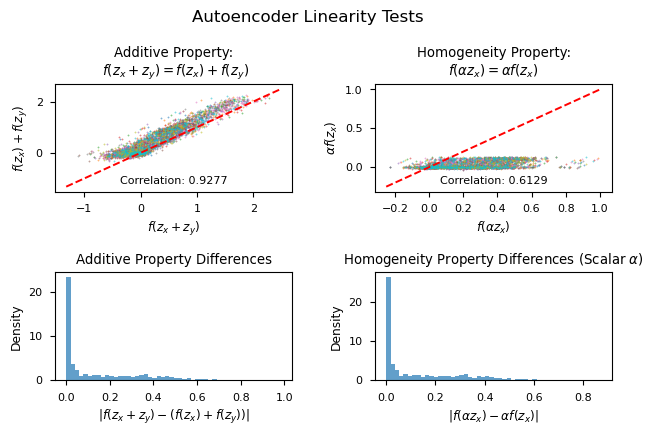

In [19]:
report.linearity_tests_analysis(model, X)

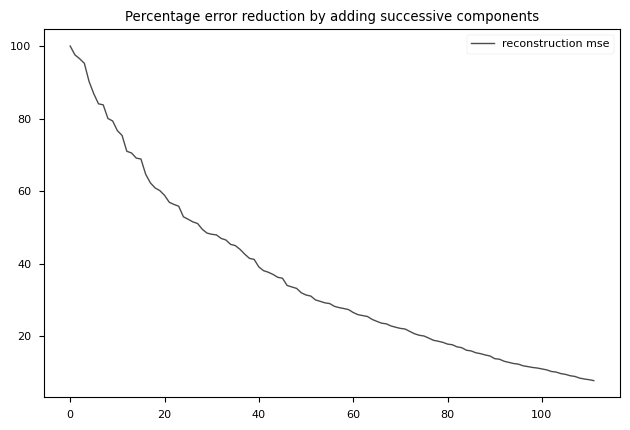

In [20]:
report.plot_cumsum_variance(model, X)

In [21]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for label in range(10):
        ax.scatter(X[y == label, 0], X[y == label, 1], label=label)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [22]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = plot2d_analysis(Xpca, y_train, title="PCA transform", legend=True)
with o2:
    _, _ = plot2d_analysis(latents, y_train, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [23]:
o1 = widgets.Output()
o2 = widgets.Output()
o3 = widgets.Output()
o4 = widgets.Output()

with o1:
    fig1, ax1 = plot2d_analysis(X, y_train, "Original data two first componets", legend=False)

with o2:
    latents, reconstructed = model.predict(X)
    fig2, ax2 = plot2d_analysis(np.round(reconstructed, 1), y_train, title="Reconstructed with POLCA all componets", legend=False)

with o3:
    latents, reconstructed = model.predict(X)
    fig3, ax3 = plot2d_analysis(np.round(reconstructed, 1), y_train, title="Reconstructed with POLCA two componets", legend=False)

with o4:
    fig4, ax4 = plot2d_analysis(np.round(pca.inverse_transform(Xpca), 1), y_train, "Reconstructed with PCA two componets", legend=False)


layout = widgets.Layout(grid_template_columns="repeat(2, 450px)")
accordion = widgets.GridBox(children=[o1, o2, o3, o4], layout=layout)
display(accordion)

GridBox(children=(Output(), Output(), Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 450p…

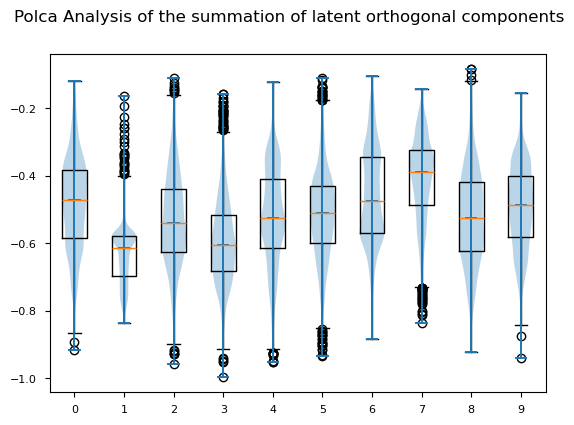

In [24]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y_train == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [25]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [26]:
model.std_metrics

array([1.06497198e-01, 8.51934776e-02, 6.69624135e-02, 4.98990379e-02,
       1.22131985e-02, 2.89505091e-03, 2.10525817e-03, 3.92409391e-04,
       1.07998517e-03, 4.24575235e-04, 8.41488771e-04, 6.92380709e-04,
       1.16096612e-03, 4.11989284e-04, 3.87800479e-04, 1.34486196e-04,
       6.73154485e-04, 4.47473663e-04, 5.80851512e-04, 2.08946629e-04,
       5.78236650e-04, 5.15279477e-04, 1.97556685e-04, 1.60264317e-04,
       4.88413032e-04, 2.37653774e-04, 2.58642016e-04, 2.32531311e-04,
       5.44729352e-04, 3.00248124e-04, 1.22227633e-04, 8.60096116e-05,
       2.84212409e-04, 1.34256828e-04, 3.88284709e-04, 1.36643343e-04,
       2.38683642e-04, 3.06056463e-04, 2.54912564e-04, 1.06075189e-04,
       3.43904598e-04, 2.68123957e-04, 1.00067147e-04, 1.39766751e-04,
       1.63527511e-04, 1.00071018e-04, 3.16527148e-04, 1.41086159e-04,
       1.19056909e-04, 1.98555863e-04, 2.17205146e-04, 1.41359400e-04,
       2.23269279e-04, 1.32485773e-04, 1.67060949e-04, 1.01553385e-04,
      

In [27]:
model.mean_metrics

array([-1.66950181e-01, -1.26072347e-01, -1.71458498e-01, -5.31627648e-02,
        3.96597490e-04,  2.16447097e-05, -3.39977014e-05,  1.84915064e-06,
       -6.24643872e-05,  9.62755712e-06,  2.18437290e-05,  2.06167556e-06,
        5.20837893e-05,  7.83894757e-06, -3.00476904e-06, -7.27837460e-06,
        2.96591934e-05,  1.30091860e-06, -3.39962071e-06,  3.34440938e-06,
       -4.32658726e-06, -1.63903351e-05,  5.77666526e-07, -1.57049521e-06,
        5.97953476e-06,  1.95899133e-06, -6.70973122e-06,  6.79364484e-06,
       -8.15427211e-06, -4.46782724e-06, -3.00594877e-07, -1.88445051e-06,
       -8.00180715e-07, -1.30343574e-06, -7.94141670e-06, -2.06379104e-06,
        8.10092160e-07, -7.41247277e-06, -1.47253968e-05, -1.55473185e-06,
        2.18984096e-05, -1.20918985e-05, -1.71475040e-06, -3.39276335e-06,
       -1.04298206e-05, -1.14941895e-06, -1.48407480e-05,  1.14451086e-06,
       -2.19226035e-06, -5.86435817e-06,  4.42802775e-06, -4.75646630e-06,
       -2.31288936e-06, -

## Test Classification with two components on PCA vs POLCA Net

In [28]:
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import minmax_scale, scale
from sklearn.svm import SVC

In [29]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.3, random_state=42)

In [30]:
X_train_pca = pca.transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))
X_train_pca.shape, X_test_pca.shape

((35000, 28), (15000, 28))

In [31]:
# Transform the data using POLCA-Net
# X_train_polca = model.predict(X_train,np.array([1, 1, 0, 0]))[0][:,:2]
X_train_polca = model.predict(X_train)[0][:, :8]
# X_test_polca = model.predict(X_test, np.array([1, 1, 0, 0]))[0][:,:2]
X_test_polca = model.predict(X_test)[0][:, :8]
X_train_polca.shape, X_test_polca.shape

((35000, 8), (15000, 8))

In [32]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": SVC(kernel="linear", probability=True),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(),
}

In [33]:
# Train and evaluate classifiers on both PCA and POLCA-Net transformed datasets
results = []

for name, clf in classifiers.items():
    # Train on PCA
    clf.fit(minmax_scale(X_train_pca), y_train)
    y_pred_pca = clf.predict(minmax_scale(X_test_pca))
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
    cm_pca = confusion_matrix(y_test, y_pred_pca)

    # Train on POLCA-Net
    clf.fit(minmax_scale(X_train_polca), y_train)
    y_pred_polca = clf.predict(minmax_scale(X_test_polca))
    accuracy_polca = accuracy_score(y_test, y_pred_polca)
    report_polca = classification_report(y_test, y_pred_polca, output_dict=True)
    cm_polca = confusion_matrix(y_test, y_pred_polca)

    # Append results
    results.append(
        {
            "Classifier": name,
            "Transformation": "PCA",
            "Accuracy": accuracy_pca,
            "Precision": report_pca["weighted avg"]["precision"],
            "Recall": report_pca["weighted avg"]["recall"],
            "F1-Score": report_pca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_pca,
        }
    )

    results.append(
        {
            "Classifier": name,
            "Transformation": "POLCA-Net",
            "Accuracy": accuracy_polca,
            "Precision": report_polca["weighted avg"]["precision"],
            "Recall": report_polca["weighted avg"]["recall"],
            "F1-Score": report_polca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_polca,
        }
    )

/data/conda/envs/python312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/conda/envs/python312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [34]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the main metrics table
main_metrics_df = results_df.drop(columns=["Confusion Matrix"])
main_metrics_df

,Classifier,Transformation,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,PCA,0.866533,0.873530,0.866533,0.867284
1,Logistic Regression,POLCA-Net,0.517000,0.508503,0.517000,0.509046
2,Gaussian Naive Bayes,PCA,0.846000,0.854931,0.846000,0.847992
3,Gaussian Naive Bayes,POLCA-Net,0.524267,0.515331,0.524267,0.513363
4,Linear SVM,PCA,0.902200,0.905563,0.902200,0.902332
5,Linear SVM,POLCA-Net,0.535467,0.528270,0.535467,0.528084
6,Ridge Classifier,PCA,0.818067,0.820495,0.818067,0.815907
7,Ridge Classifier,POLCA-Net,0.460600,0.461904,0.460600,0.421629
8,Perceptron,PCA,0.851133,0.858436,0.851133,0.851506
9,Perceptron,POLCA-Net,0.391733,0.512846,0.391733,0.351551


In [35]:
# Statistical test: Paired t-test for accuracies
pca_accuracies = results_df[results_df["Transformation"] == "PCA"]["F1-Score"]
polca_accuracies = results_df[results_df["Transformation"] == "POLCA-Net"]["F1-Score"]

t_stat, p_value = ttest_rel(pca_accuracies.values, polca_accuracies.values)

print(f"\nPaired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the PCA and POLCA-Net transformations.")
else:
    print("There is no statistically significant difference between the PCA and POLCA-Net transformations.")


Paired t-test results: t-statistic = 13.696308374157288, p-value = 0.00016461083335866326
There is a statistically significant difference between the PCA and POLCA-Net transformations.


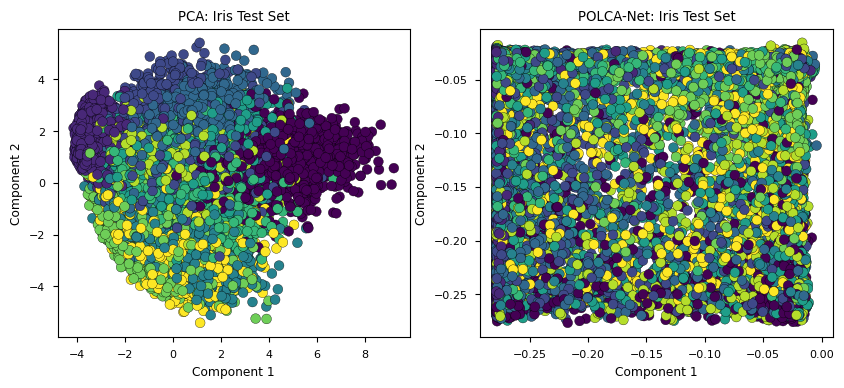

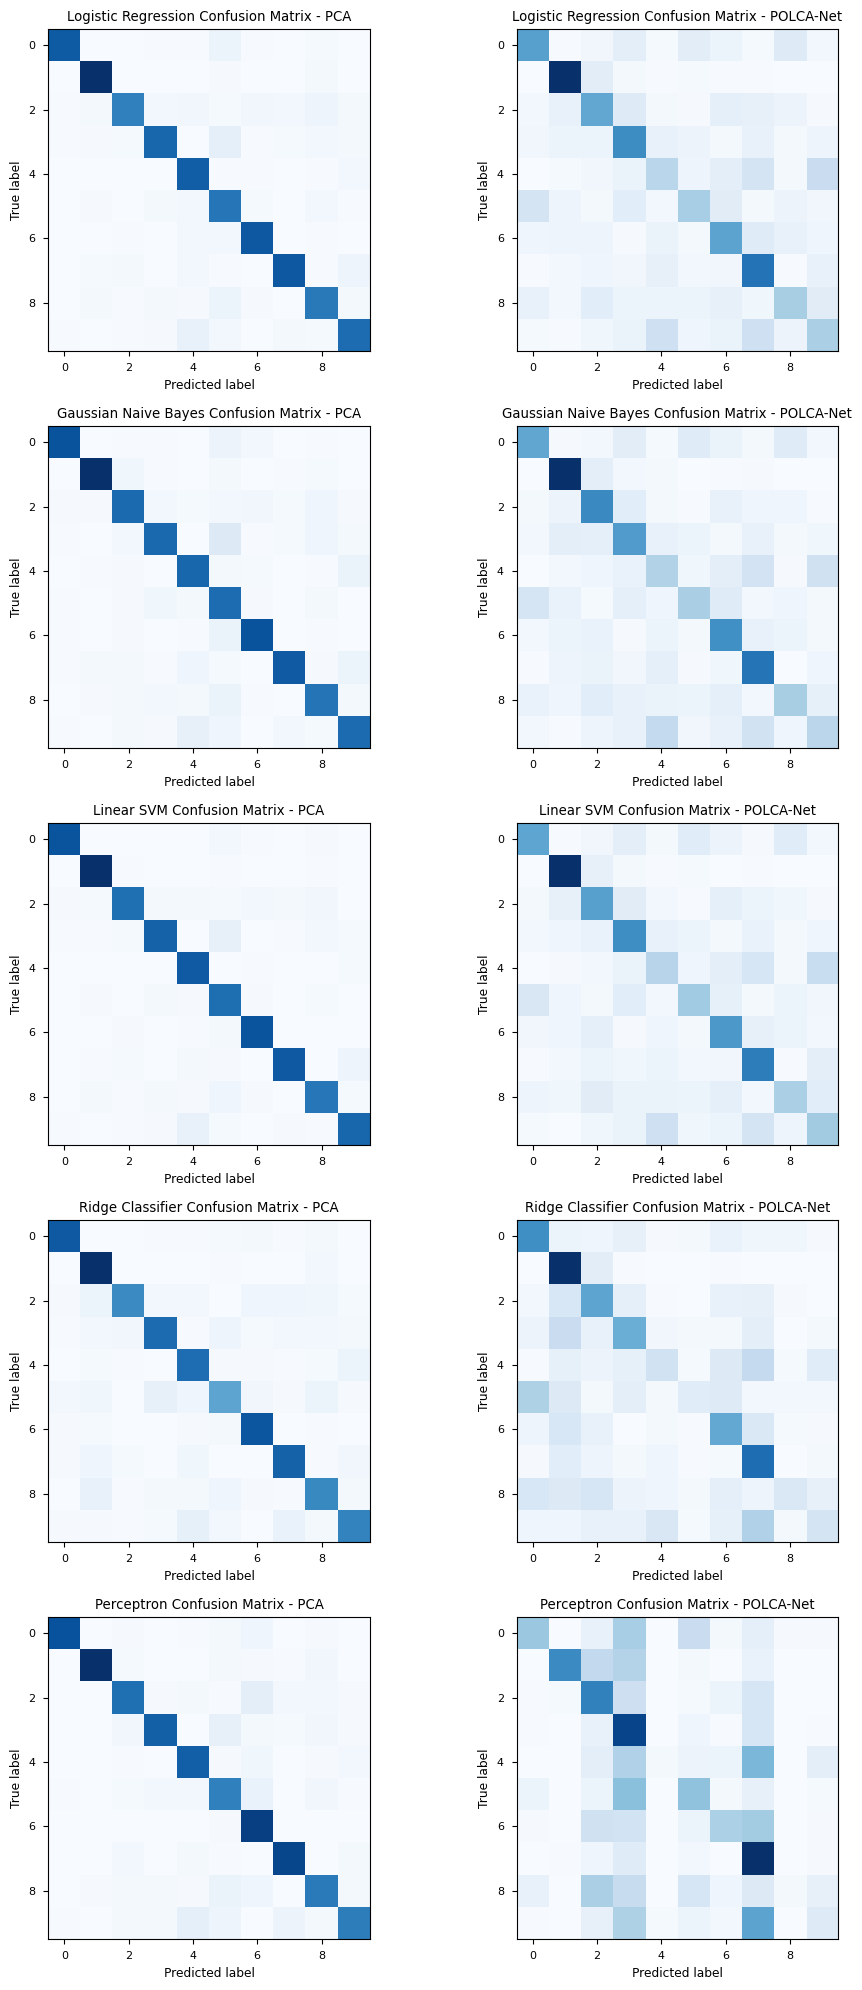

In [36]:
# Plotting the results
plt.figure(figsize=(10, 4))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="viridis", edgecolor="k", s=50)
plt.title("PCA: Iris Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Plot POLCA-Net
plt.subplot(1, 2, 2)
plt.scatter(X_test_polca[:, 0], X_test_polca[:, 1], c=y_test, cmap="viridis", edgecolor="k", s=50)
plt.title("POLCA-Net: Iris Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

# Plot Confusion Matrices for each classifier
fig, axes = plt.subplots(len(classifiers), 2, figsize=(10, 20))

for i, (name, clf) in enumerate(classifiers.items()):
    # PCA Confusion Matrix
    cm_pca = results_df[(results_df["Classifier"] == name) & (results_df["Transformation"] == "PCA")]["Confusion Matrix"].values[0]
    axes[i, 0].imshow(cm_pca, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i, 0].set_title(f"{name} Confusion Matrix - PCA")
    axes[i, 0].set_xlabel("Predicted label")
    axes[i, 0].set_ylabel("True label")

    # POLCA-Net Confusion Matrix
    cm_polca = results_df[(results_df["Classifier"] == name) & (results_df["Transformation"] == "POLCA-Net")]["Confusion Matrix"].values[0]
    axes[i, 1].imshow(cm_polca, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i, 1].set_title(f"{name} Confusion Matrix - POLCA-Net")
    axes[i, 1].set_xlabel("Predicted label")
    axes[i, 1].set_ylabel("True label")

plt.tight_layout()
plt.show()